In [1]:
using Plots; pyplot()
using DelimitedFiles
using AugmentedGaussianProcesses
using KernelFunctions;

In [2]:
X = readdlm("data/banana_X_train")
Y = readdlm("data/banana_Y_train")[:];

In [3]:
# Run sparse classification with increasing number of inducing points
Ms = [4, 8, 16, 32, 64]
models = Vector{AbstractGP}(undef,length(Ms)+1)
kernel = SqExponentialKernel(1.0)
for (index, num_inducing) in enumerate(Ms)
    @info "Training with $(num_inducing) points"
    m = SVGP(X, Y, kernel,LogisticLikelihood(),AnalyticVI(),num_inducing)
    @time train!(m,20)
    models[index]=m;
end

┌ Info: Training with 4 points
└ @ Main In[3]:6


 12.806569 seconds (46.89 M allocations: 2.481 GiB, 8.20% gc time)


┌ Info: Training with 8 points
└ @ Main In[3]:6


  0.117281 seconds (932.15 k allocations: 220.592 MiB, 27.48% gc time)


┌ Info: Training with 16 points
└ @ Main In[3]:6


  0.174798 seconds (932.43 k allocations: 352.832 MiB, 25.07% gc time)


┌ Info: Training with 32 points
└ @ Main In[3]:6


  0.304894 seconds (933.02 k allocations: 618.853 MiB, 21.82% gc time)


┌ Info: Training with 64 points
└ @ Main In[3]:6


  0.622581 seconds (934.61 k allocations: 1.130 GiB, 16.72% gc time)


In [4]:
@info "Running full model"
mfull = VGP(X, Y, kernel,LogisticLikelihood(),AnalyticVI())
@time train!(mfull,5);
models[end] = mfull;

┌ Info: Running full model
└ @ Main In[4]:1


 37.581410 seconds (6.47 M allocations: 15.820 GiB, 4.04% gc time)


In [80]:
function compute_Grid(model,nGrid=50)
    mins = [-3.25,-2.85]
    maxs = [3.65,3.4]
    xlin = range(mins[1],maxs[1],length=nGrid)
    ylin = range(mins[2],maxs[2],length=nGrid)
    Xplot = Iterators.product(xlin,ylin)
    y,_ =  proba_y(model,copy(hcat(collect.(Xplot)...)'))
    return (y,xlin,ylin)
    end;

In [81]:
function plotdata(X,Y)
    Plots.plot(X[Y.==1,1],X[Y.==1,2],alpha=0.2,t=:scatter,markerstrokewidth=0.0,lab="",size=(300,500));
    Plots.plot!(X[Y.==-1,1],X[Y.==-1,2],alpha=0.2,t=:scatter,markerstrokewidth=0.0,lab="",size=(300,500));
end;

In [83]:
function plotcontour(model,X,Y)
    nGrid = 40
    (predic,x,y) = compute_Grid(model,nGrid);
    p = plotdata(X,Y)
    Plots.plot!(p,x,y,reshape(predic,nGrid,nGrid),cbar=false,t=:contour,levels=[0.5],fill=false,color=:black,linewidth=2.0,title=(model isa SVGP ? "M = $(model.nFeatures)" : "full"))
    if model isa SVGP
        Plots.plot!(p,model.f[1].Z[:,1],model.f[1].Z[:,2],msize=2.0,color="black",t=:scatter,lab="")
    end
    return p
end;

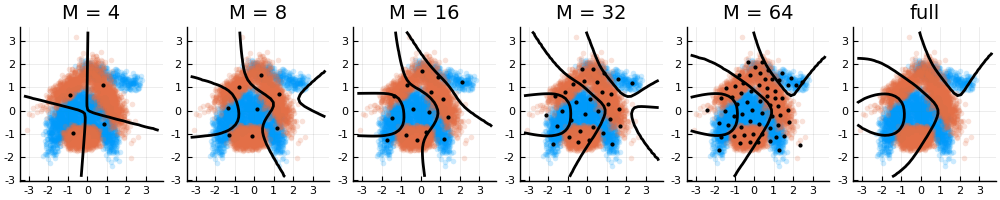

In [84]:
Plots.plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))